In [73]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self, layer_sizes=[16, 128, 128, 16], bias=False, device=None):
        super().__init__()
        layers = [layer for i, size in enumerate(layer_sizes[:-1]) for layer in (nn.Linear(size, layer_sizes[i+1], bias, device), nn.ReLU())]
        self.layers = nn.Sequential(*layers[:-1])
    
    def forward(self, x):
        return self.layers(x)
    
def split_MLP(model, n_parts):
    n_lin_layers = len([l for l in model.layers if isinstance(l, nn.Linear)])
    assert n_parts <= n_lin_layers
    
    starts = t.linspace(0, len(model.layers), n_parts + 1).int()[:-1]
    ends = t.linspace(0, len(model.layers), n_parts + 1).int()[1:]
    
    models = [nn.Sequential(*model.layers[s:e]) for s, e in zip(starts, ends)]
    
    return models

def split_MLP_and_save(model, n_parts, filename_pattern = 'mlp-%d.pt'):
    models = split_MLP(model, n_parts)
    for i, model in enumerate(models):
        t.save(model, filename_pattern % i)
        

###################################################################

# Trains model on the identity function
def train(model, batch_size=256, n_steps=10):
    
    shape = (batch_size, model.layers[0].in_features)
    data = lambda: (t.rand(shape) * 2 - 1).detach()
    
    optimizer = t.optim.Adam(model.parameters())
    loss_fn = t.nn.MSELoss()
    
    losses = []
    with tqdm(range(n_steps)) as pbar:
        for i in pbar:
            x = data()

            optimizer.zero_grad()
            y = model(x)
            loss = loss_fn(x, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.detach())
            pbar.set_postfix({'loss': float(loss)})
            
    return losses

In [83]:
model = MLP([128, 256, 256, 256, 128])
split_MLP_and_save(model, 4)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 341.79it/s, loss=0.0559]


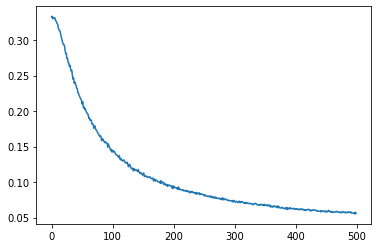

In [84]:
losses = train(model, n_steps=500)
plt.plot(losses);

In [70]:
model.layers[0]

Linear(in_features=32, out_features=128, bias=False)